<a href="https://colab.research.google.com/github/usmor/russian-cefr-aligner/blob/main/finetuning/project_nlp1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Дообучение BERT

базово bert-base-uncased

In [ ]:
!git clone https://github.com/usmor/russian-cefr-aligner/

fatal: destination path 'russian-cefr-aligner' already exists and is not an empty directory.


In [ ]:
CUDA_LAUNCH_BLOCKING=1

In [ ]:
!pip install transformers datasets==3.6.0 peft accelerate evaluate seqeval scikit-learn matplotlib seaborn conllu -q

тут разберись, какие лишние, удали

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import (
    AutoModelForSequenceClassification,
    AutoModelForTokenClassification,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
from peft import get_peft_model, LoraConfig
from google.colab import files
import evaluate
import time
import os

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
train_data = pd.read_csv('/content/russian-cefr-aligner/data/train_dataset.csv').rename(columns={"cefr_level":'labels'})
val_data = pd.read_csv('/content/russian-cefr-aligner/data/val_dataset.csv').rename(columns={"cefr_level":'labels'})
test_data = pd.read_csv('/content/russian-cefr-aligner/data/test_dataset.csv').rename(columns={"cefr_level":'labels'})

In [ ]:
train_data = Dataset.from_pandas(train_data).class_encode_column("labels")
val_data = Dataset.from_pandas(val_data).class_encode_column("labels")
test_data = Dataset.from_pandas(test_data).class_encode_column("labels")

Casting to class labels:   0%|          | 0/21163 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/2646 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/2645 [00:00<?, ? examples/s]

## Дообучение всего BERT

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=6)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

train_data = train_data.map(tokenize, batched=True)
val_data = val_data.map(tokenize, batched=True)
test_data = test_data.map(tokenize, batched=True)

Map:   0%|          | 0/21163 [00:00<?, ? examples/s]

Map:   0%|          | 0/2646 [00:00<?, ? examples/s]

Map:   0%|          | 0/2645 [00:00<?, ? examples/s]

In [ ]:
test_data

Dataset({
    features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2645
})

In [ ]:
metrics_list = []

metric1 = evaluate.load("accuracy")
metric2 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = metric1.compute(predictions=predictions, references=labels)
    f1_score = metric2.compute(predictions=predictions, references=labels, average='weighted')

    metrics = {'eval_accuracy' : accuracy['accuracy'],
              'eval_f1-score': f1_score['f1']}
    metrics_list.append(metrics)
    return metrics

In [ ]:
training_args = TrainingArguments(
    output_dir="base_bert_cefr",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    num_train_epochs=20,
    weight_decay=0.01,
    learning_rate=2e-5,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model='eval_f1-score',
    greater_is_better=True,
    fp16=True,
    dataloader_pin_memory=True
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

start = time.time()
trainer.train()
end = time.time()

train_time = end - start
print(f'Дообучение заняло {train_time}')

Epoch,Training Loss,Validation Loss,Accuracy,F1-score
1,1.373000,1.328291,0.459940,0.465064
2,1.159800,1.193804,0.526833,0.511651
3,1.046400,1.140635,0.543840,0.552977
4,0.938900,1.140134,0.564626,0.568089
5,0.795900,1.080971,0.593348,0.595291
6,0.701000,1.137852,0.592215,0.595228
7,0.583900,1.206511,0.597506,0.597701
8,0.515300,1.289424,0.606198,0.604994
9,0.424500,1.401042,0.613757,0.614725
10,0.351800,1.475742,0.611867,0.610788


Дообучение заняло 9663.970447778702


In [ ]:
test_predictions = trainer.predict(test_data)
test_metrics = test_predictions.metrics

In [ ]:
trained_acc = [m['eval_accuracy'] for m in metrics_list]
trained_f1 = [m['eval_f1'] for m in metrics_list]

final_acc = trained_acc[-1]
final_f1 = trained_f1[-1]

mean_acc = sum(trained_acc)/len(trained_acc)
mean_f1 = sum(trained_f1)/len(trained_f1)

In [ ]:
results_dict = {'Средняя accuracy': [mean_acc, 0.0, 0.0],
                'Средняя f1-score': [mean_f1, 0.0, 0.0],
                'accuracy на тесте': [final_acc, 0.0, 0.0],
                'f1-score на тесте': [final_f1, 0.0, 0.0],
                'accuracy' : [trained_acc, 0.0, 0.0],
                'f1-score': [trained_f1, 0.0, 0.0]
                }

results_data = pd.DataFrame(results_dict, index=['Дообученный BERT', 'LoRA на BERT', 'RuBERT'])
results_data.to_csv('results_BERT.csv')


In [ ]:
files.download('results_BERT.csv')

# Дообучение адаптера LoRA

In [ ]:
lora_model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=6)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, # классификация
    r = 8,
    lora_alpha = 16, # параметры с семинара
    lora_dropout = 0.05,
    target_modules = ['query', 'value'],
    bias='none'

)

In [ ]:
lora_model = get_peft_model(lora_model, lora_config)

In [ ]:
training_args_lora = TrainingArguments(
    output_dir="lora_cefr",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    num_train_epochs=14, # наилучший результат при дообучении всего BERT
    weight_decay=0.01,
    learning_rate=2e-5,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model='eval_f1-score',
    greater_is_better=True,
    fp16=True,
    dataloader_pin_memory=True
)

lora_trainer = Trainer(
    model=lora_model,
    args=training_args_lora,
    train_dataset=train_data,
    eval_dataset=val_data,
    compute_metrics=compute_metrics
)

start = time.time()
lora_trainer.train()
end = time.time()

lora_train_time = end - start
print(f'Дообучение заняло {lora_train_time}')

Epoch,Training Loss,Validation Loss,Accuracy,F1-score
1,1.741000,1.637751,0.318972,0.261894
2,1.583300,1.518753,0.382464,0.349049
3,1.520500,1.473102,0.399471,0.373357
4,1.475300,1.434640,0.418745,0.395106
5,1.432500,1.415615,0.426682,0.404196
6,1.424100,1.400382,0.429327,0.423149
7,1.398500,1.397664,0.426304,0.421014
8,1.383600,1.387696,0.433485,0.424886
9,1.379200,1.373318,0.443689,0.436147
10,1.365400,1.377948,0.437264,0.427407


Дообучение заняло 6650.437242269516


In [ ]:
lora_test_predictions = lora_trainer.predict(test_data)
lora_test_metrics = lora_test_predictions.metrics

In [ ]:
lora_metrics = metrics_list
trained_acc_lora = [m['eval_accuracy'] for m in lora_metrics]
trained_f1_lora = [m['eval_f1-score'] for m in lora_metrics]

final_acc_lora = trained_acc_lora[-1]
final_f1_lora = trained_f1_lora[-1]

mean_acc_lora = sum(trained_acc_lora)/len(trained_acc_lora)
mean_f1_lora = sum(trained_f1_lora)/len(trained_f1_lora)

In [ ]:
trained_f1_lora

[0.26189421894942483,
 0.34904865476809716,
 0.3733568141701438,
 0.39510626661190085,
 0.4041960978125152,
 0.423149008593227,
 0.421014299260775,
 0.4248856890893468,
 0.43614719383556894,
 0.4274073519539283,
 0.4254039746661816,
 0.42563566417877213,
 0.43360088093567595,
 0.435994198383301,
 0.43535844585714717]

In [ ]:
results_dict = {'Средняя accuracy': [0.0, mean_acc_lora, 0.0],
                'Средняя f1-score': [0.0, mean_f1_lora, 0.0],
                'accuracy на тесте': [0.0, final_acc_lora, 0.0],
                'f1-score на тесте': [0.0, final_f1_lora, 0.0],
                'accuracy' : [0.0, trained_acc_lora, 0.0],
                'f1-score': [0.0, trained_f1_lora, 0.0]
                }

results_data = pd.DataFrame(results_dict, index=['Дообученный BERT', 'LoRA на BERT', 'RuBERT'])
results_data.to_csv('results_LoRA.csv')


Сводим в общую таблицу BERT и LoRA

In [ ]:
results_bert = pd.read_csv('/content/results_BERT.csv')
results_lora = pd.read_csv('/content/results_LoRA.csv')

In [ ]:
results_bert = results_bert.T
results_bert[1] = results_lora.T[1]
results_bert = results_bert.T

In [ ]:
results_bert.to_csv('results_bert&lora.csv')

# RuBERT

Полное дообучение показало существенно лучшие результаты --> будем полностью дообучать ruBERT

In [ ]:
ru_tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
ru_model = AutoModelForSequenceClassification.from_pretrained("DeepPavlov/rubert-base-cased", num_labels=6, ignore_mismatched_sizes=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize(examples):
    return ru_tokenizer(examples["text"], padding="max_length", truncation=True)

train_data = train_data.map(tokenize, batched=True)
val_data = val_data.map(tokenize, batched=True)
test_data = test_data.map(tokenize, batched=True)

Map:   0%|          | 0/21163 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/2646 [00:00<?, ? examples/s]

Map:   0%|          | 0/2645 [00:00<?, ? examples/s]

In [ ]:
ru_training_args = TrainingArguments(
    output_dir="ru_bert_cefr",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    num_train_epochs=20,
    weight_decay=0.01,
    learning_rate=2e-5,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model='eval_f1-score',
    save_total_limit=1,
    greater_is_better=True,
    fp16=True,
    dataloader_pin_memory=True
)

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=ru_tokenizer)

In [ ]:
ru_trainer = Trainer(
    model=ru_model,
    args=ru_training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

start = time.time()
ru_trainer.train()
end = time.time()

train_time = end - start
print(f'Дообучение заняло {train_time}')

Epoch,Training Loss,Validation Loss,Accuracy,F1-score
1,0.921400,0.792564,0.690854,0.689625
2,0.572500,0.732480,0.727135,0.728946
3,0.345300,0.839357,0.726757,0.730135
4,0.233700,1.039382,0.737717,0.736583
5,0.169700,1.342391,0.735450,0.738187
6,0.102400,1.507120,0.746032,0.746763
7,0.078700,1.678711,0.751701,0.752390
8,0.069600,1.818435,0.738095,0.738115
9,0.051300,1.755397,0.749811,0.750182
10,0.047500,1.991741,0.743764,0.743353


Дообучение заняло 2210.578448534012


In [ ]:
ru_test_predictions = ru_trainer.predict(test_data)
ru_test_metrics = ru_test_predictions.metrics

In [ ]:
ru_trained_acc = [m['eval_accuracy'] for m in metrics_list]
ru_trained_f1 = [m['eval_f1-score'] for m in metrics_list]

ru_final_acc = ru_trained_acc[-1]
ru_final_f1 = ru_trained_f1[-1]

ru_mean_acc = sum(ru_trained_acc)/len(ru_trained_acc)
ru_mean_f1 = sum(ru_trained_f1)/len(ru_trained_f1)

In [ ]:
results_dict = {'Средняя accuracy': [ 0.0, 0.0, ru_mean_acc],
                'Средняя f1-score': [ 0.0, 0.0, ru_mean_f1],
                'accuracy на тесте': [0.0, 0.0, ru_final_acc],
                'f1-score на тесте': [0.0, 0.0, ru_final_f1],
                'accuracy' : [0.0, 0.0, ru_trained_acc],
                'f1-score': [0.0, 0.0, ru_trained_f1]
                }

results_data = pd.DataFrame(results_dict, index=['Дообученный BERT', 'LoRA на BERT', 'RuBERT'])
results_data.to_csv('results_ruBERT.csv')


In [ ]:
files.download('results_ruBERT.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Попытка сохранить дообученную модель

In [ ]:
!zip -r ru_bert_cefr.zip ru_bert_cefr/
files.download('ru_bert_cefr.zip')

	zip warning: Local Version Needed To Extract does not match CD: checkpoint-13230/scheduler.pt
	zip warning: Local Version Needed To Extract does not match CD: checkpoint-13230/rng_state.pth
	zip warning: Local Version Needed To Extract does not match CD: checkpoint-13230/training_args.bin
	zip warning: Local Version Needed To Extract does not match CD: checkpoint-13230/trainer_state.json
	zip warning: Local Version Needed To Extract does not match CD: checkpoint-13230/tokenizer.json
	zip warning: Local Version Needed To Extract does not match CD: checkpoint-13230/special_tokens_map.json
	zip warning: Local Version Needed To Extract does not match CD: checkpoint-13230/scaler.pt
	zip warning: Local Version Needed To Extract does not match CD: checkpoint-2646/tokenizer_config.json
	zip warning: Local Version Needed To Extract does not match CD: checkpoint-2646/config.json
	zip warning: Local Version Needed To Extract does not match CD: checkpoint-2646/vocab.txt
	zip warning: Local Versio

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Собираем общую таблицу

In [ ]:
all_res = pd.read_csv('/content/results_bert&lora.csv')

In [ ]:
results_rubert = pd.read_csv('/content/results_ruBERT.csv')

In [ ]:
all_res = all_res.T
all_res[2] = results_rubert.T[2]
all_res = all_res.T

In [ ]:
all_res.drop(['Unnamed: 0.1'], axis=1, inplace=True)
all_res = all_res.rename(columns={'Unnamed: 0':'Модель'})

In [ ]:
all_res

,Модель,Средняя accuracy,Средняя f1-score,accuracy на тесте,f1-score на тесте,accuracy,f1-score
0,Дообученный BERT,0.592059,0.592705,0.624717,0.624,"[0.45994, 0.526833, 0.54384, 0.564626, 0.59334...","[0.465064, 0.511651, 0.552977, 0.568089, 0.595..."
1,LoRA на BERT,0.421679,0.404813,0.442344,0.435358,"[0.31897203325774753, 0.382464096749811, 0.399...","[0.26189421894942483, 0.34904865476809716, 0.3..."
2,RuBERT,0.733997,0.734744,0.726654,0.72791,"[0.690854119425548, 0.72713529856387, 0.726757...","[0.6896251970019308, 0.728945982922866, 0.7301..."


In [ ]:
all_res.to_csv('all_results_cefr.csv', index=False)

In [ ]:
all_acc = [list(map(float, acc.strip('[]').split(', '))) for acc in list(all_res['accuracy'])]

In [ ]:
all_f1 = [list(map(float, f1.strip('[]').split(', '))) for f1 in list(all_res['f1-score'])]

Общий график

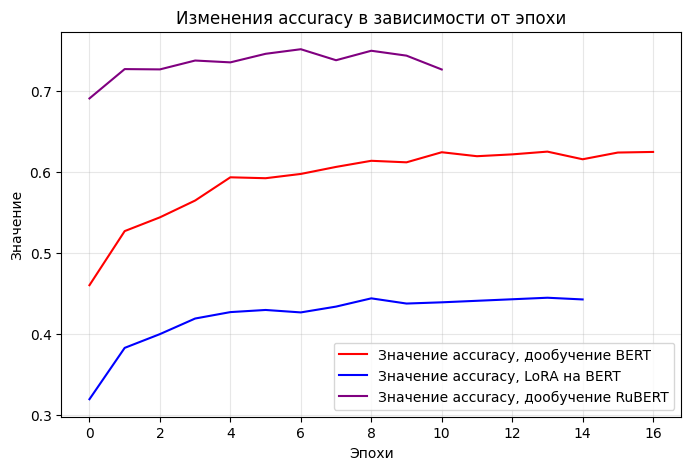

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(all_acc[0], label='Значение accuracy, дообучение BERT', color='red')
plt.plot(all_acc[1], label='Значение accuracy, LoRA на BERT', color='blue')
plt.plot(all_acc[2], label='Значение accuracy, дообучение RuBERT', color='purple')

plt.xlabel('Эпохи')
plt.ylabel('Значение')
plt.title('Изменения accuracy в зависимости от эпохи')
plt.grid(True, alpha=0.3)
plt.legend()

plt.savefig('accuracy_epoch.png', dpi=300, bbox_inches='tight')

plt.show()

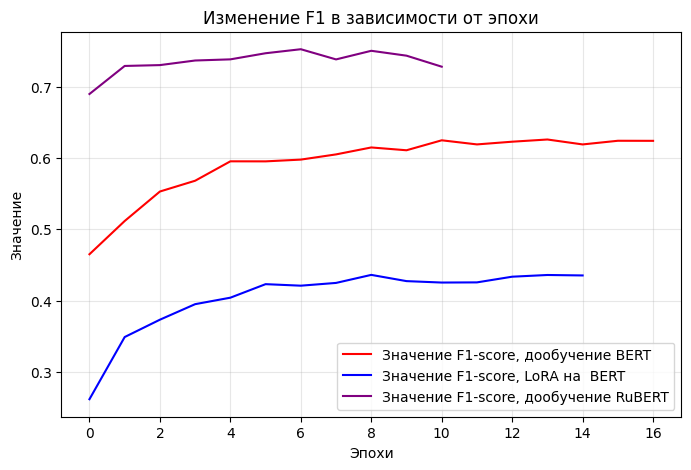

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(all_f1[0], label='Значение F1-score, дообучение BERT', color='red')
plt.plot(all_f1[1], label='Значение F1-score, LoRA на  BERT', color='blue')
plt.plot(all_f1[2], label='Значение F1-score, дообучение RuBERT', color='purple')


plt.xlabel('Эпохи')
plt.ylabel('Значение')
plt.title('Изменение F1 в зависимости от эпохи')
plt.grid(True, alpha=0.3)
plt.legend()

plt.savefig('f1_epoch.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
plt.savefig('preformace_epoch.png', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

# Ai-forever-ruBert-base

In [ ]:
tokenizer_ru_new = AutoTokenizer.from_pretrained("ai-forever/ruBert-base")
model_ru_new = AutoModelForSequenceClassification.from_pretrained("ai-forever/ruBert-base", num_labels=6, ignore_mismatched_sizes=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize(examples):
    return tokenizer_ru_new(examples["text"], padding="max_length", truncation=True)

train_data = train_data.map(tokenize, batched=True)
val_data = val_data.map(tokenize, batched=True)
test_data = test_data.map(tokenize, batched=True)

Map:   0%|          | 0/21163 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/2646 [00:00<?, ? examples/s]

Map:   0%|          | 0/2645 [00:00<?, ? examples/s]

In [ ]:
ru_training_args = TrainingArguments(
    output_dir="new_ru_bert_cefr",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    num_train_epochs=20,
    weight_decay=0.01,
    learning_rate=2e-5,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model='eval_f1-score',
    save_total_limit=1,
    greater_is_better=True,
    fp16=True,
    dataloader_pin_memory=True
)

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer_ru_new)

In [ ]:
ru_new_trainer = Trainer(
    model=model_ru_new,
    args=ru_training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

start = time.time()
ru_new_trainer.train()
end = time.time()

train_time = end - start
print(f'Дообучение заняло {train_time}')

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"
wandb: Using W&B in offline mode.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1-score
1,0.900200,0.821979,0.672714,0.667624
2,0.555600,0.750392,0.720711,0.723225
3,0.309100,0.893478,0.725246,0.725942
4,0.196100,1.191934,0.718065,0.719156
5,0.132500,1.438661,0.733560,0.735051
6,0.088500,1.665775,0.721466,0.724071
7,0.062100,1.892476,0.730537,0.733268
8,0.053000,1.958096,0.721088,0.721695


Дообучение заняло 3211.9046108722687


In [ ]:
metrics = ru_new_trainer.evaluate()

In [ ]:
metrics

{'eval_accuracy': 0.7335600907029478,
 'eval_f1-score': 0.7350510326254807,
 'eval_loss': 1.4386606216430664,
 'eval_runtime': 10.0562,
 'eval_samples_per_second': 263.122,
 'eval_steps_per_second': 32.915,
 'epoch': 8.0}

In [ ]:
!zip -r ru_bert_cefr.zip new_ru_bert_cefr/checkpoint-6615
files.download('ru_bert_cefr.zip')

  adding: new_ru_bert_cefr/checkpoint-6615/ (stored 0%)
  adding: new_ru_bert_cefr/checkpoint-6615/special_tokens_map.json (deflated 42%)
  adding: new_ru_bert_cefr/checkpoint-6615/optimizer.pt (deflated 43%)
  adding: new_ru_bert_cefr/checkpoint-6615/tokenizer_config.json (deflated 74%)
  adding: new_ru_bert_cefr/checkpoint-6615/model.safetensors (deflated 7%)
  adding: new_ru_bert_cefr/checkpoint-6615/tokenizer.json (deflated 73%)
  adding: new_ru_bert_cefr/checkpoint-6615/vocab.txt (deflated 66%)
  adding: new_ru_bert_cefr/checkpoint-6615/trainer_state.json (deflated 71%)
  adding: new_ru_bert_cefr/checkpoint-6615/scheduler.pt (deflated 61%)
  adding: new_ru_bert_cefr/checkpoint-6615/config.json (deflated 57%)
  adding: new_ru_bert_cefr/checkpoint-6615/scaler.pt (deflated 64%)
  adding: new_ru_bert_cefr/checkpoint-6615/rng_state.pth (deflated 26%)
  adding: new_ru_bert_cefr/checkpoint-6615/training_args.bin (deflated 53%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>